# STOP!!! READ THIS FIRST
You should only look at these solutions once you think you have working solutions of your own :).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
plt.rc("font", size=24)
plt.rc("errorbar", capsize=3) #Ignore

<Container object of 3 artists>

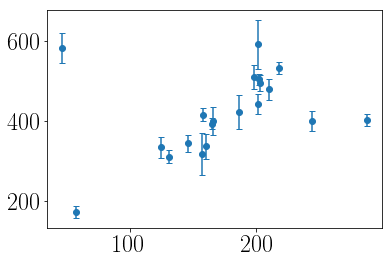

In [2]:
#Exercises 6 and 7
#Get the data. We only want x, y and the error on y
_, x_all, y_all, sigy_all, _, _ = np.genfromtxt("data.txt", unpack=True, delimiter='&', skip_header=1)
x    = x_all
y    = y_all
sigy = sigy_all
plt.errorbar(x, y, sigy, marker='o', ls='')

In [3]:
#Write our likelihood. First step is a prior
def lnprior(params):
    m, b, Pb, Yb, Vb = params
    if m < 0 or b < -100: return -np.inf
    if Pb < 0 or Pb > 1: return -np.inf
    if Vb < 0 or Vb > 10000: return -np.inf
    if Yb < 0 or Yb > 1000: return -np.inf
    return 0

#Now a probability
def lnprob(params, x, y, sigy):
    m, b, Pb, Yb, Vb = params
    left  = (1.-Pb)/np.sqrt(2*np.pi*sigy**2)*np.exp(-0.5*(y-m*x-b)**2/sigy**2)
    right = Pb/np.sqrt(2*np.pi*(Vb+sigy**2))*np.exp(-0.5*(y-Yb)**2/(Vb+sigy**2))
    return np.sum(np.log(left+right))

#Now the total likelihood
def lnlike(params, x, y ,sigy):
    lp = lnprior(params)
    if not np.isfinite(lp): return -np.inf
    return lp + lnprob(params, x, y, sigy)

guess = [2., .3, 0.2, 1.0, 2.0]
print lnlike(guess, x, y, sigy)

-361.747882166


   direc: array([[ -1.63718969e-03,   7.10827564e-01,  -9.07237699e-05,
         -8.05453349e-01,   7.44337172e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00],
       [ -2.42306718e-02,   4.50903915e+00,  -1.16764395e-03,
         -2.46371840e+00,   4.98411885e+01]])
     fun: 105.17507522070329
 message: 'Optimization terminated successfully.'
    nfev: 363
     nit: 6
  status: 0
 success: True
       x: array([  2.26095245e+00,   3.18339887e+01,   2.57592733e-01,
         4.46791695e+02,   5.07271686e+03])


/home/tom/anaconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


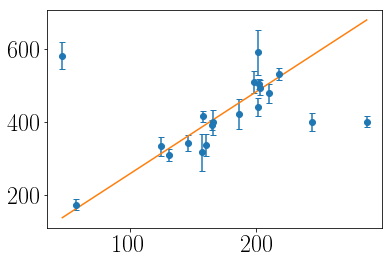

In [4]:
#Start by sampling with a maximum likelihood approach
from scipy import optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, guess, args=(x, y, sigy), method='Powell')
plt.errorbar(x, y, sigy, marker='o', ls='')
m, b = result['x'][:2]
domain = np.linspace(min(x), max(x), 100)
plt.plot(domain, m*domain+b)
print result

In [5]:
#Set up an MCMC using emcee
import emcee
ndim, nwalkers = 5, 20
nsteps = 10000
pos = [result['x'] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(x, y, sigy))
output = sampler.run_mcmc(pos, nsteps) #We don't use "output" at all

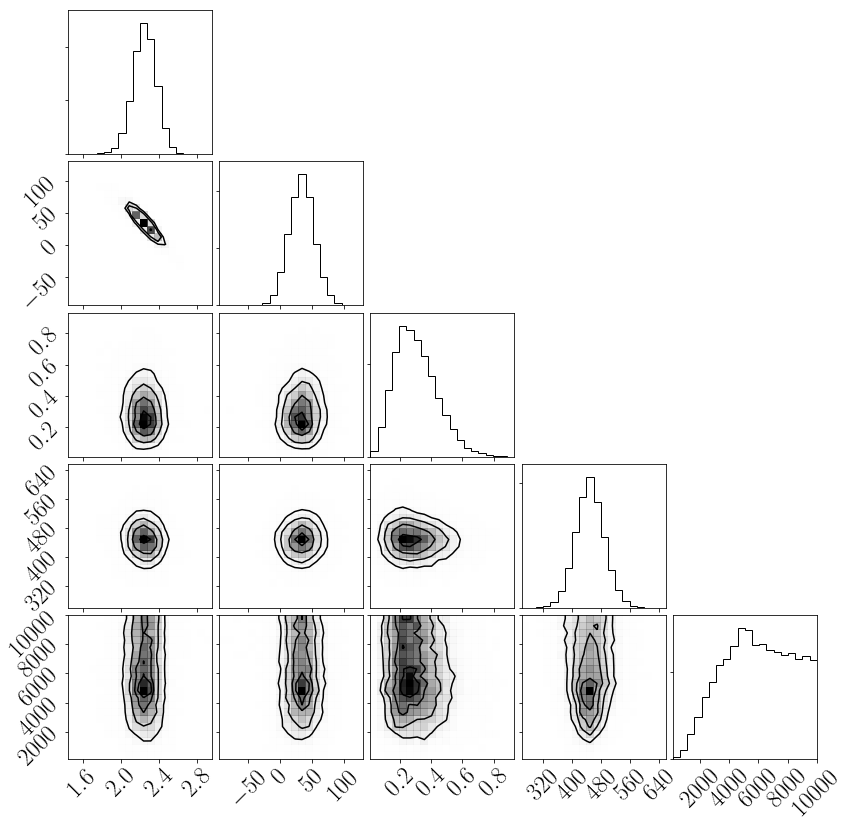

In [6]:
#See the results with a corner
import corner
nburn = 5000
chain = sampler.flatchain[nburn*nwalkers:] #Chop off the "burn in"
fig = corner.corner(chain, plot_datapoints=False)

As seen in the corner plot, we have the 2D plot of $m$ and $b$ in the top left and the pdf of $P_b$ along the diagonal.

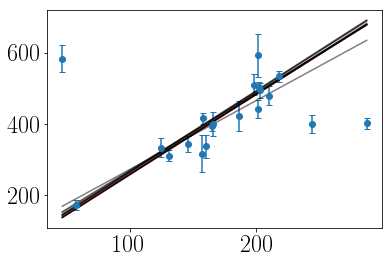

In [7]:
#Here is our plot with some samples from the chain
plt.errorbar(x, y, sigy, marker='o', ls='')
m, b = np.mean(chain, 0)[:2]
domain = np.linspace(min(x), max(x), 100)
plt.plot(domain, m*domain+b, c='r')
mysamples = chain[np.random.randint(0, len(chain), 10), :2]
for mi, bi in mysamples: plt.plot(domain, mi*domain+bi, c='k',alpha=0.5)

/home/tom/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/home/tom/anaconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/home/tom/anaconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:1852: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)


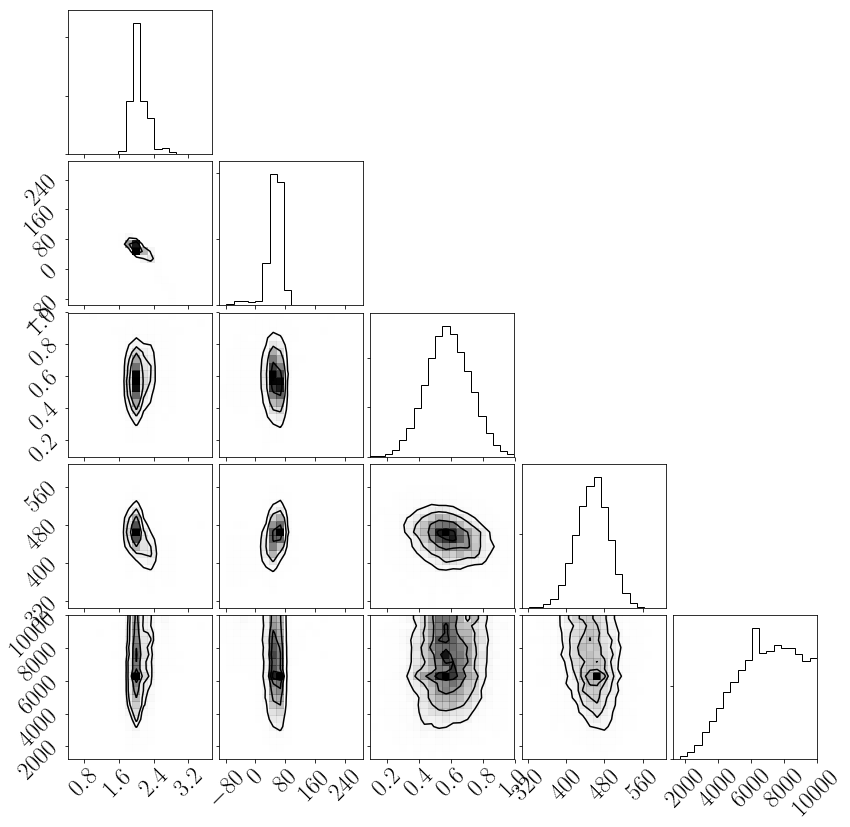

In [8]:
#Repeat everything with sigy = sigy/2
result2 = op.minimize(nll, guess, args=(x, y, sigy/2), method='Powell')
pos2 = [result2['x'] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(x, y, sigy/2))
output2 = sampler2.run_mcmc(pos2, nsteps) #We don't use "output2" at all
chain2 = sampler2.flatchain[nburn*nwalkers:] #Chop off the "burn in"
fig = corner.corner(chain2, plot_datapoints=False)

The answer to the second part of Exercise 7 is in the middle most diagonal histogram. We see that the PDF for $P_b$ shifted to ~0.6.